In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.boolean_reasoning"

In [2]:
#instead of installing library...
from config import library_path,snapshot_path

AgentNet examples will store and seek thier snapshots at /home/jheuristic/yozhik/agentnet_snapshots/


In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


/home/jheuristic/thenv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [4]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [5]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1~3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 = (not X1) and X2
 - Y2 = not Y1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will converge to a strategy of polling X for as long as they yield information
on Y, and 

In [6]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step GRU
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [7]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [8]:
import lasagne

#only 10 hidden neurons
n_hid=10


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [9]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [10]:
#produce interaction sequences of length <= 10
history = agent.get_sessions(env,session_length=10,
                       batch_size=env.batch_size,)

state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


In [11]:

#Let us compile a function that returns all interaction logs
get_history = theano.function([],history+(is_alive_seq,rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights
 
 
 #### Get (prediction,reference) pairs

In [12]:
#get pairs of corresponding [predicted Qvalues, reference Qvalues] to train on

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')

ref_tuples = env.get_reference(qvalues_seq,
                               action_seq,
                               rewards_seq,
                               is_alive_seq,
                               gamma_or_gammas=gamma,)


action_Qvalues, reference_Qvalues,_ = ref_tuples

In [13]:
#prevent gradient updates over reference Qvalues (since they depend on predicted Qvalues)
from agentnet.utils import consider_constant
reference_Qvalues = consider_constant(reference_Qvalues)

#### Define loss functions

In [14]:
#tensor of elementwise squared errors
squared_error = lasagne.objectives.squared_error(reference_Qvalues,action_Qvalues)

#zero-out ticks after session ended
squared_error = squared_error * is_alive_seq

#compute average of squared error sums per session
session_mse_loss = squared_error.sum(axis = 1).mean()

In [15]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [16]:
loss = session_mse_loss + reg_l2

#### Compute weight updates

In [17]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [18]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [19]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,session_mse_loss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [20]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,reference_Qvalues,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, reference_qv_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   hidden_seq=hidden_log,
                   reference_qvalues_seq = reference_qv_log,
                   action_names=env.feature_names,
                  
                  plot_qvalues = with_plots)

session # 0
 X1(qv = 0.0) -> 1.0(ref = 1.05806291103) |  X2(qv = 0.0611188784242) -> 1.0(ref = 1.09214043617) |  X1(qv = 0.0969899594784) -> -0.5(ref = -0.41486030817) |  X2(qv = 0.0896207243204) -> -0.5(ref = -0.381499409676) |  X1(qv = 0.124737456441) -> -0.5(ref = -0.40775001049) |  X2(qv = 0.0971052497625) -> -0.5(ref = -0.373933762312) |  X3(qv = -0.0222272872925) -> -1.0(ref = -0.925024032593) |  X1(qv = 0.078922085464) -> -0.5(ref = -0.437280893326) |  Y2(qv = 0.0282501522452) -> 3.0(ref = 3.1075398922) |  X1(qv = 0.113199785352) -> -0.5(ref = -0.5) |

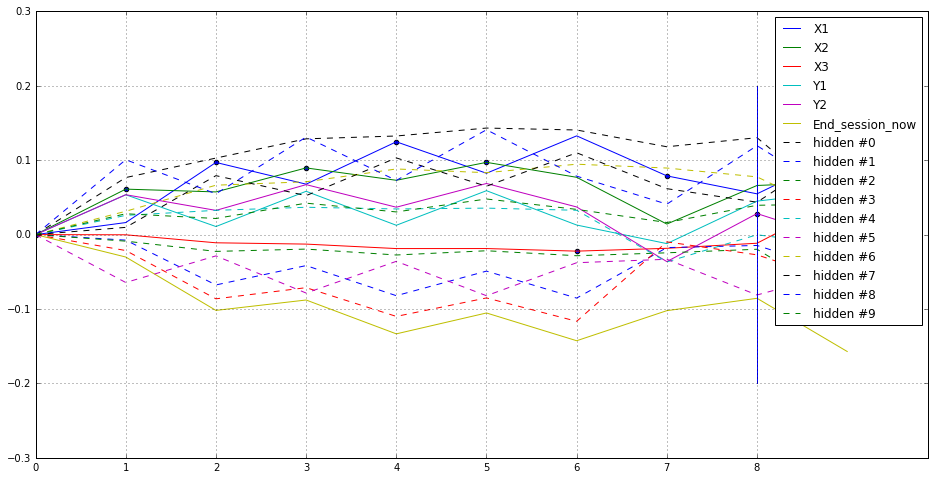

In [21]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [22]:
from agentnet.utils.persistence import save,load

In [23]:
from agentnet.display import Metrics
score_log = Metrics()

In [24]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 14.47436, epsilon 0.96275, rewards: ( e-greedy 0.05000, greedy 0.00000) 
rec 14.462 reg 0.013
epoch 200,loss 7.50794, epsilon 0.92696, rewards: ( e-greedy 0.07833, greedy 0.00000) 
rec 7.495 reg 0.013
epoch 300,loss 5.44096, epsilon 0.89257, rewards: ( e-greedy 0.00383, greedy -0.06667) 
rec 5.428 reg 0.013
epoch 400,loss 11.73295, epsilon 0.85954, rewards: ( e-greedy -0.27988, greedy -0.19333) 
rec 11.720 reg 0.013
epoch 500,loss 11.59694, epsilon 0.82779, rewards: ( e-greedy -0.55189, greedy -0.30733) 
rec 11.584 reg 0.013
epoch 600,loss 9.39412, epsilon 0.79730, rewards: ( e-greedy -0.79671, greedy -0.50993) 
rec 9.381 reg 0.013
epoch 700,loss 15.81686, epsilon 0.76799, rewards: ( e-greedy -0.50037, greedy -0.37561) 
rec 15.803 reg 0.013
epoch 800,loss 11.49533, epsilon 0.73984, rewards: ( e-greedy -0.71700, greedy -0.48805) 
rec 11.482 reg 0.014
epoch 900,loss 17.79674, epsilon 0.71279, rewards: ( e-greedy -0.79530, greedy -0.35591) 
rec 17.783 reg 0.014
epoch 1000,l

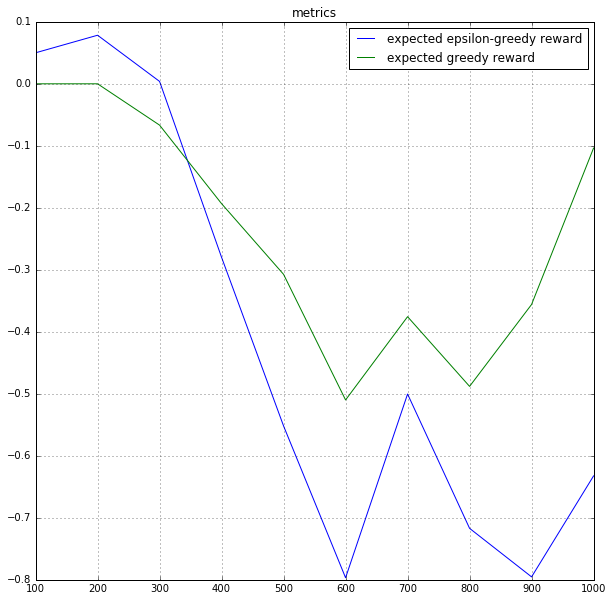

Random session examples
session # 0
 Y1(qv = -0.350152671337) -> -3.0(ref = -2.58240842819) |  End_session_now(qv = 0.174915224314) -> 0.0(ref = 0.231683433056) |  Y1(qv = -0.161482751369) -> 0.0(ref = 0.0) | 



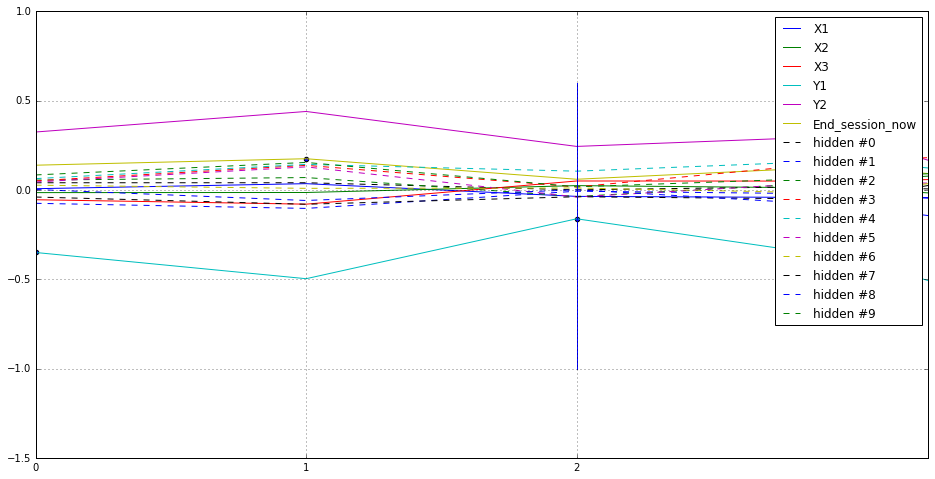

session # 1
 Y1(qv = -0.350152671337) -> -3.0(ref = -2.58240842819) |  X1(qv = 0.0352710820735) -> 1.0(ref = 1.3674697876) |  X3(qv = -0.147572740912) -> -1.0(ref = -0.643167495728) |  X1(qv = -0.017177991569) -> -0.5(ref = -0.209521412849) |  X3(qv = -0.192455649376) -> -0.5(ref = -0.211092114449) |  X1(qv = -0.0573968291283) -> -0.5(ref = -0.259632647038) |  End_session_now(qv = 0.107517592609) -> 0.0(ref = 0.0618049427867) |  Y2(qv = 0.065057836473) -> 0.0(ref = 0.0) | 



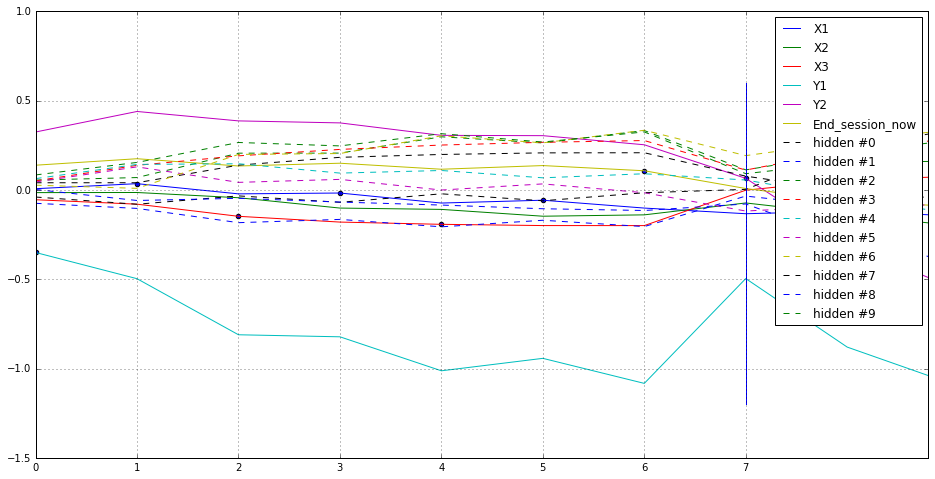

session # 2
 X1(qv = 0.00702782999724) -> -1.0(ref = -0.570163309574) |  X1(qv = -0.035187266767) -> -0.5(ref = -0.0203071534634) |  Y2(qv = 0.504939854145) -> 3.0(ref = 3.01224756241) |  End_session_now(qv = 0.0128920525312) -> 0.0(ref = 0.0518596284091) |  X3(qv = 0.0545890815556) -> 0.0(ref = 0.0) | 



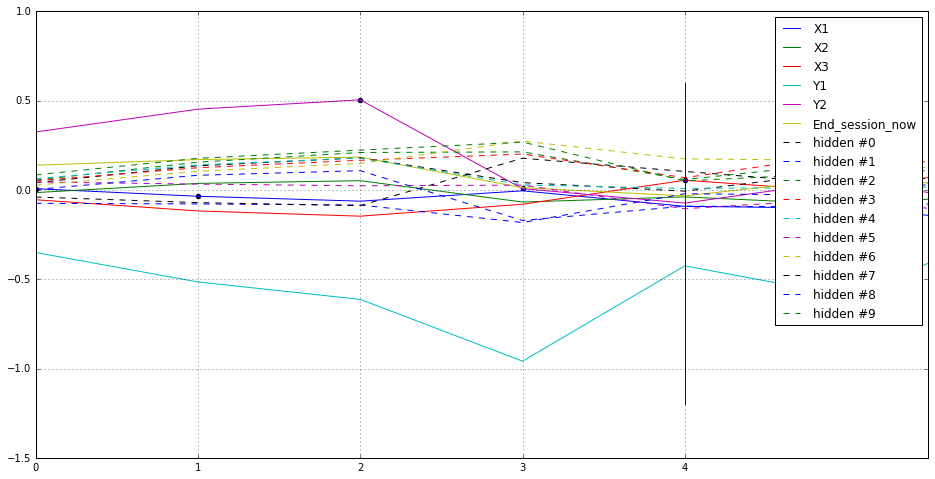

epoch 1100,loss 12.70410, epsilon 0.66183, rewards: ( e-greedy -0.68586, greedy -0.05995) 
rec 12.689 reg 0.015
epoch 1200,loss 11.11926, epsilon 0.63784, rewards: ( e-greedy -0.50061, greedy 0.26271) 
rec 11.104 reg 0.016
epoch 1300,loss 6.35017, epsilon 0.61479, rewards: ( e-greedy -0.16721, greedy 0.55311) 
rec 6.334 reg 0.016
epoch 1400,loss 10.07703, epsilon 0.59265, rewards: ( e-greedy -0.08382, greedy 0.79779) 
rec 10.060 reg 0.017
epoch 1500,loss 7.74295, epsilon 0.57137, rewards: ( e-greedy 0.30789, greedy 1.11802) 
rec 7.725 reg 0.018
epoch 1600,loss 11.03982, epsilon 0.55093, rewards: ( e-greedy 0.26044, greedy 1.12288) 
rec 11.022 reg 0.018
epoch 1700,loss 8.83686, epsilon 0.53129, rewards: ( e-greedy 0.50106, greedy 1.41059) 
rec 8.818 reg 0.019
epoch 1800,loss 4.60960, epsilon 0.51241, rewards: ( e-greedy 0.43429, greedy 1.53620) 
rec 4.590 reg 0.019
epoch 1900,loss 5.70239, epsilon 0.49428, rewards: ( e-greedy 0.54086, greedy 1.78258) 
rec 5.682 reg 0.020
epoch 2000,loss

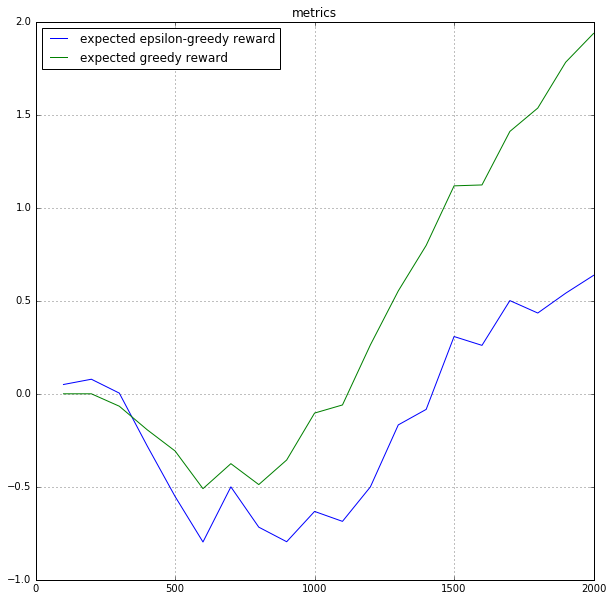

Random session examples
session # 0
 Y2(qv = 0.806823790073) -> 3.0(ref = 3.15252804756) |  X1(qv = 0.160555928946) -> 1.0(ref = 1.0517885685) |  X1(qv = -0.0448196418583) -> -0.5(ref = -0.459863245487) |  Y1(qv = -1.48589110374) -> -3.0(ref = -2.88984966278) |  X2(qv = -0.0355964489281) -> 1.0(ref = 1.11014533043) |  End_session_now(qv = 0.115942403674) -> 0.0(ref = 0.0308450590819) |  X3(qv = 0.032468482852) -> 0.0(ref = 0.0) | 



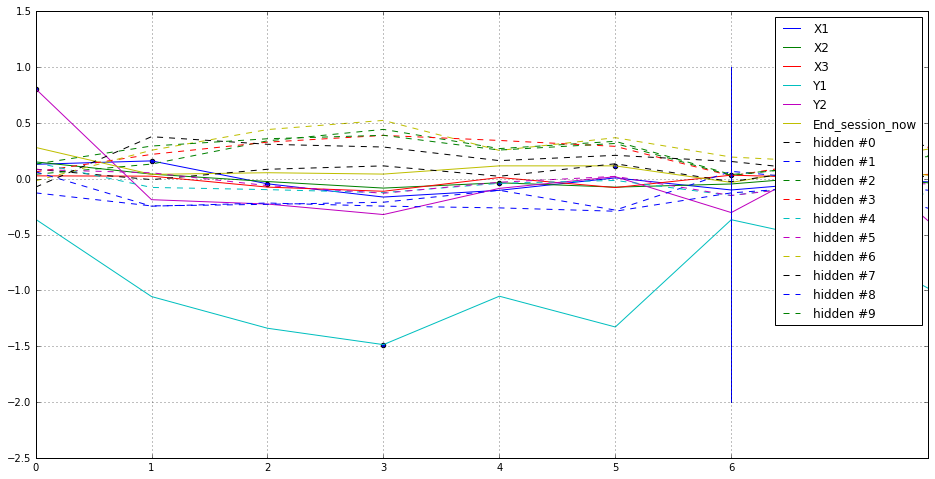

session # 1
 Y2(qv = 0.806823790073) -> 3.0(ref = 3.15252804756) |  Y2(qv = -0.187107026577) -> -0.5(ref = -0.503301143646) |  X1(qv = -0.00347490981221) -> 1.0(ref = 0.961038708687) |  X3(qv = -0.0958878993988) -> 1.0(ref = 0.973373830318) |  End_session_now(qv = -0.0280275642872) -> 0.0(ref = 0.00507020624354) |  Y2(qv = -0.890876054764) -> 0.0(ref = 0.0) | 



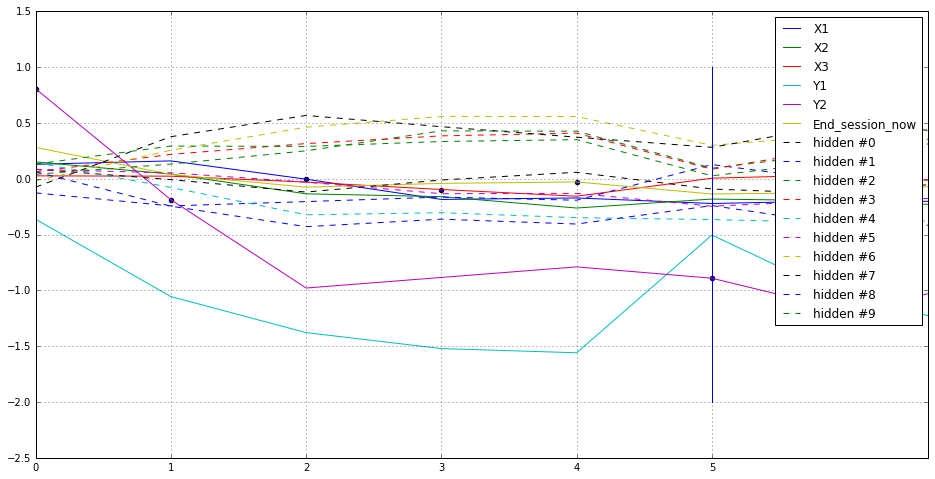

session # 2
 Y2(qv = 0.806823790073) -> 3.0(ref = 3.15252804756) |  X1(qv = 0.160555928946) -> 1.0(ref = 1.0517885685) |  End_session_now(qv = 0.0545142889023) -> 0.0(ref = 0.0372395254672) |  X1(qv = -0.132602915168) -> 0.0(ref = 0.0) | 



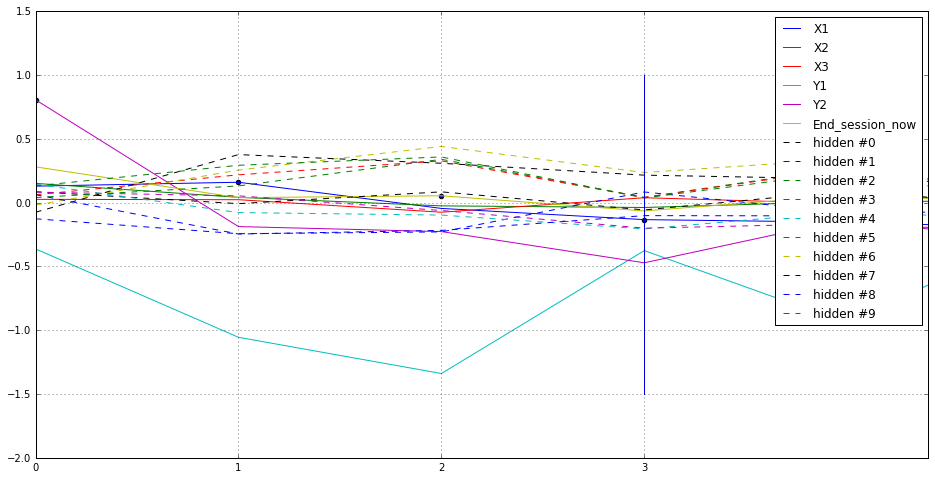

epoch 2100,loss 17.87902, epsilon 0.46012, rewards: ( e-greedy 0.57309, greedy 1.64389) 
rec 17.858 reg 0.021
epoch 2200,loss 9.97941, epsilon 0.44404, rewards: ( e-greedy 0.69912, greedy 1.61283) 
rec 9.957 reg 0.022
epoch 2300,loss 11.95786, epsilon 0.42859, rewards: ( e-greedy 0.56254, greedy 1.61822) 
rec 11.935 reg 0.023
epoch 2400,loss 5.94200, epsilon 0.41375, rewards: ( e-greedy 0.70629, greedy 1.60640) 
rec 5.918 reg 0.024
epoch 2500,loss 3.60874, epsilon 0.39949, rewards: ( e-greedy 0.86899, greedy 1.64576) 
rec 3.584 reg 0.025
epoch 2600,loss 4.31488, epsilon 0.38578, rewards: ( e-greedy 1.04876, greedy 1.78118) 
rec 4.290 reg 0.025
epoch 2700,loss 7.73426, epsilon 0.37262, rewards: ( e-greedy 1.04388, greedy 1.80306) 
rec 7.709 reg 0.026
epoch 2800,loss 6.76654, epsilon 0.35997, rewards: ( e-greedy 1.00616, greedy 1.62276) 
rec 6.740 reg 0.026
epoch 2900,loss 8.85766, epsilon 0.34781, rewards: ( e-greedy 0.98888, greedy 1.52715) 
rec 8.831 reg 0.026
epoch 3000,loss 2.37860,

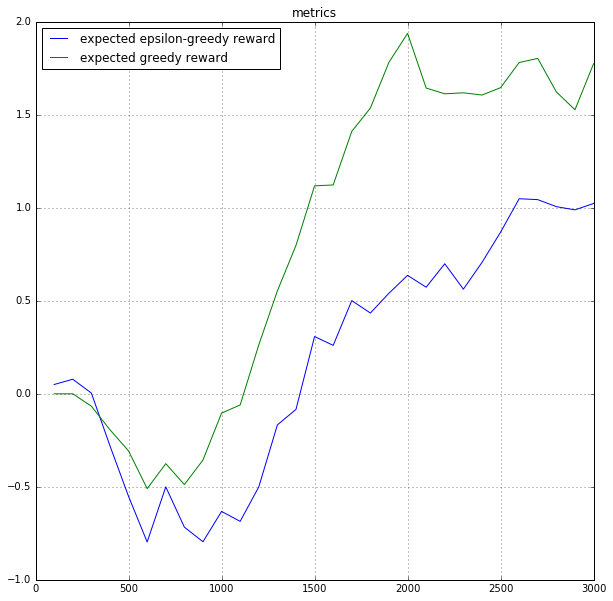

Random session examples
session # 0
 X1(qv = 0.264711201191) -> 1.0(ref = 2.18687224388) |  X2(qv = 0.311880111694) -> 1.0(ref = 1.60016715527) |  Y2(qv = 0.631754934788) -> 3.0(ref = 2.88012766838) |  X3(qv = -0.137350082397) -> -1.0(ref = -1.08406400681) |  End_session_now(qv = -0.0884884297848) -> 0.0(ref = -0.0484690181911) |  X3(qv = -0.0510200187564) -> 0.0(ref = 0.0) | 



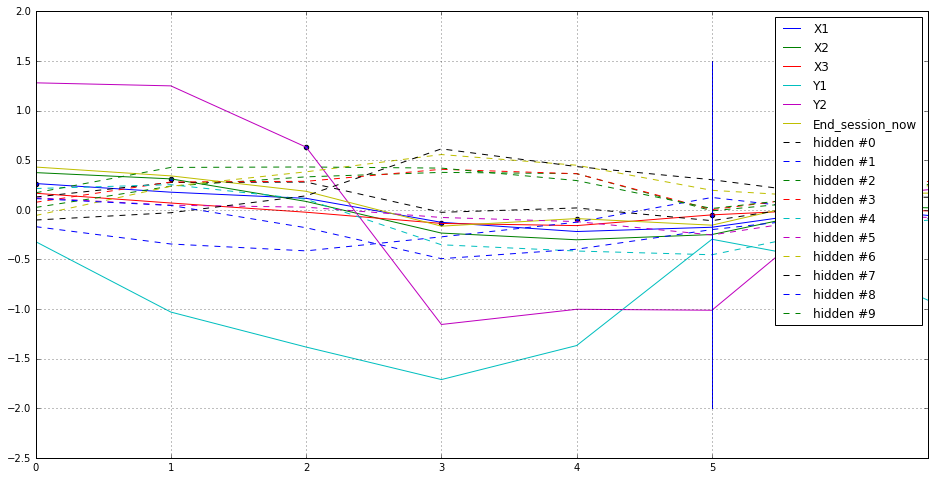

session # 1
 Y2(qv = 1.28002309799) -> -3.0(ref = -2.6015484333) |  X1(qv = 0.300211191177) -> -1.0(ref = -0.482401549816) |  X3(qv = 0.133999496698) -> 1.0(ref = 1.43394780159) |  Y2(qv = 0.456787109375) -> -0.5(ref = -0.487479925156) |  X3(qv = 0.0131790116429) -> -0.5(ref = -0.503977000713) |  End_session_now(qv = -0.00418630242348) -> 0.0(ref = -0.0481568202376) |  X1(qv = -0.150529295206) -> 0.0(ref = 0.0) | 



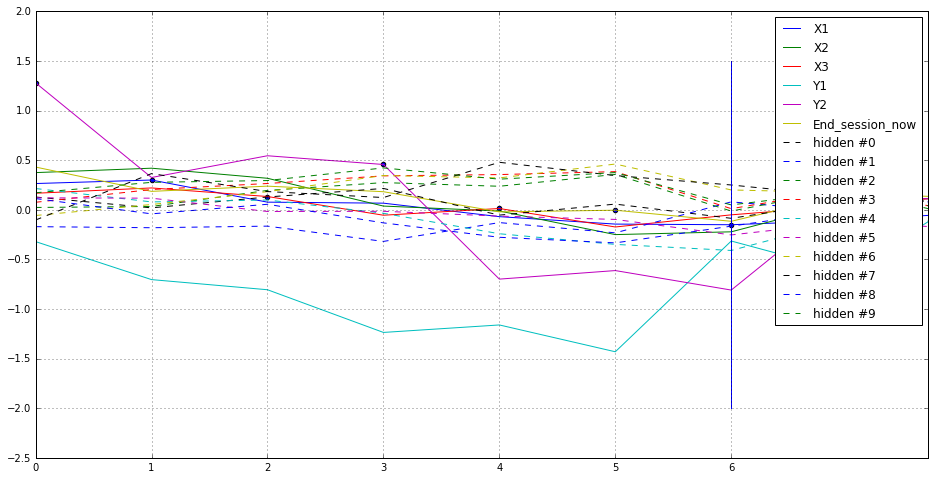

session # 2
 X2(qv = 0.374941468239) -> -1.0(ref = 0.619258522987) |  Y2(qv = 1.7044826746) -> 3.0(ref = 3.25447463989) |  Y2(qv = -0.200091719627) -> -0.5(ref = -0.632890462875) |  X1(qv = -0.13988468051) -> 1.0(ref = 0.804720699787) |  X1(qv = -0.44566065073) -> -0.5(ref = -0.69788646698) |  Y1(qv = -1.82563948631) -> -3.0(ref = -3.06670165062) |  End_session_now(qv = -0.0702122747898) -> 0.0(ref = -0.016351820901) |  X3(qv = -0.0172124430537) -> 0.0(ref = 0.0) | 



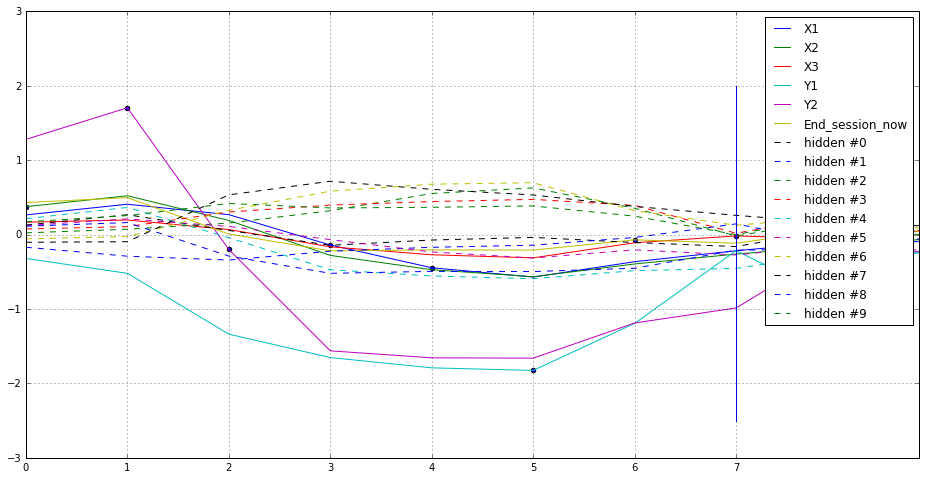

epoch 3100,loss 14.56411, epsilon 0.32492, rewards: ( e-greedy 1.02099, greedy 1.66366) 
rec 14.536 reg 0.028
epoch 3200,loss 3.06855, epsilon 0.31414, rewards: ( e-greedy 1.21889, greedy 1.89729) 
rec 3.041 reg 0.028
epoch 3300,loss 16.34332, epsilon 0.30378, rewards: ( e-greedy 1.28034, greedy 1.87423) 
rec 16.315 reg 0.029
epoch 3400,loss 13.52440, epsilon 0.29383, rewards: ( e-greedy 1.36897, greedy 1.88681) 
rec 13.495 reg 0.029
epoch 3500,loss 8.64980, epsilon 0.28427, rewards: ( e-greedy 1.34874, greedy 1.83146) 
rec 8.620 reg 0.029
epoch 3600,loss 5.02824, epsilon 0.27508, rewards: ( e-greedy 1.58053, greedy 1.98165) 
rec 4.998 reg 0.030
epoch 3700,loss 4.07470, epsilon 0.26626, rewards: ( e-greedy 1.68915, greedy 2.05015) 
rec 4.045 reg 0.030
epoch 3800,loss 13.67172, epsilon 0.25778, rewards: ( e-greedy 1.57023, greedy 1.84513) 
rec 13.641 reg 0.031
epoch 3900,loss 8.00267, epsilon 0.24963, rewards: ( e-greedy 1.47987, greedy 1.86062) 
rec 7.972 reg 0.031
epoch 4000,loss 7.61

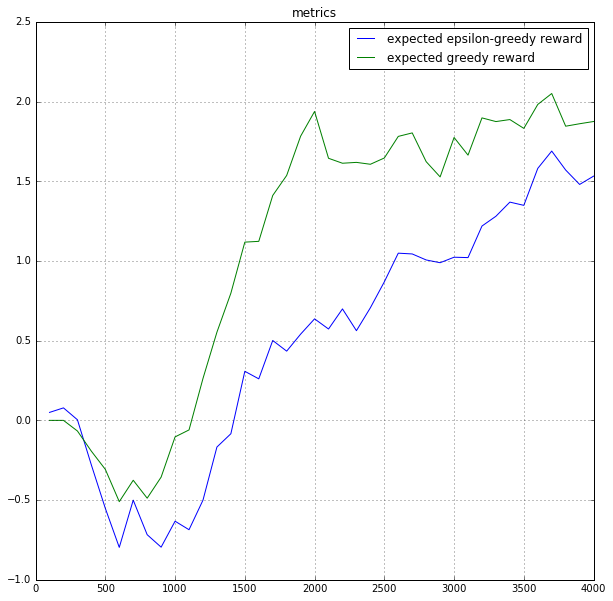

Random session examples
session # 0
 Y2(qv = 1.60167169571) -> -3.0(ref = -2.39615607262) |  X2(qv = 0.635625183582) -> 1.0(ref = 1.11990606785) |  End_session_now(qv = 0.126216962934) -> 0.0(ref = 0.068513430655) |  End_session_now(qv = -0.00154337286949) -> 0.0(ref = 0.0) | 



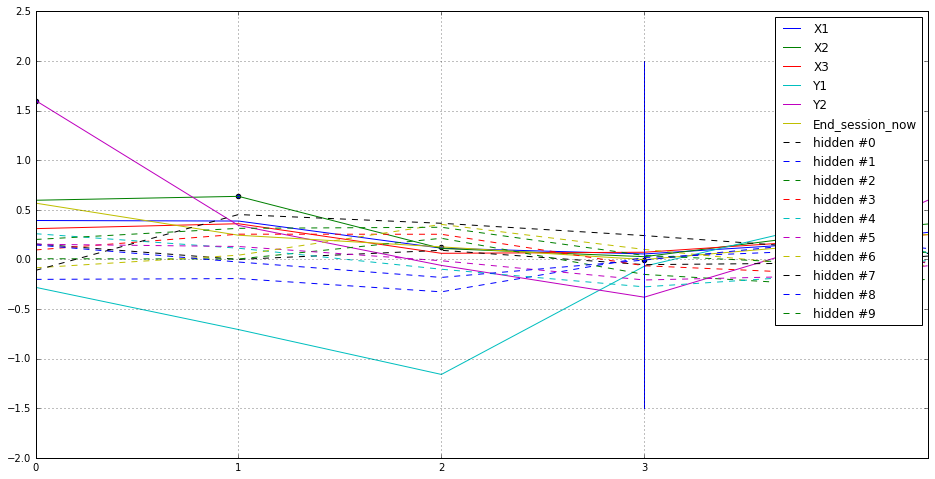

session # 1
 Y2(qv = 1.60167169571) -> 3.0(ref = 3.24471354485) |  X1(qv = 0.257593214512) -> 1.0(ref = 0.948373675346) |  X3(qv = -0.142787382007) -> 1.0(ref = 0.921902954578) |  Y2(qv = -1.01540589333) -> -0.5(ref = -0.789524674416) |  End_session_now(qv = -0.304762780666) -> 0.0(ref = -0.140369579196) |  X3(qv = -0.147757455707) -> 0.0(ref = 0.0) | 



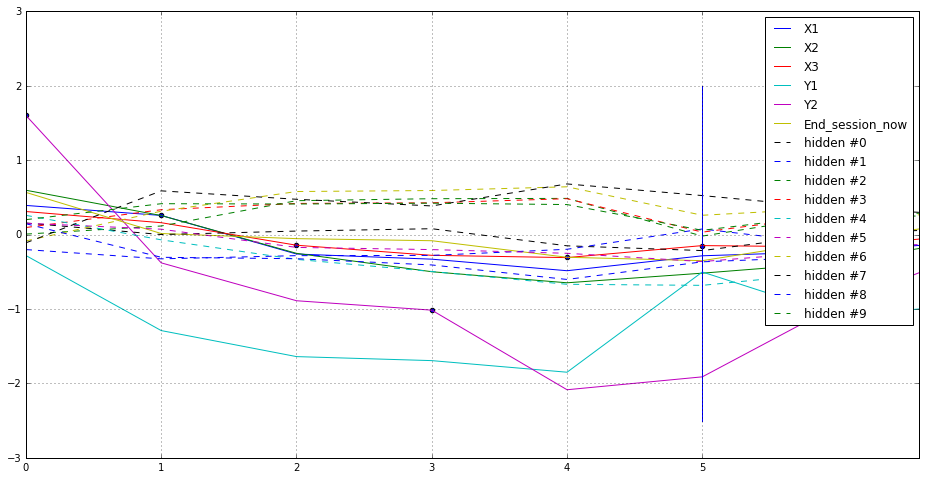

session # 2
 Y2(qv = 1.60167169571) -> 3.0(ref = 3.24471354485) |  X1(qv = 0.257593214512) -> 1.0(ref = 0.948373675346) |  End_session_now(qv = -0.0543434917927) -> 0.0(ref = -0.0442445464432) |  Y1(qv = -0.30969619751) -> 0.0(ref = 0.0) | 



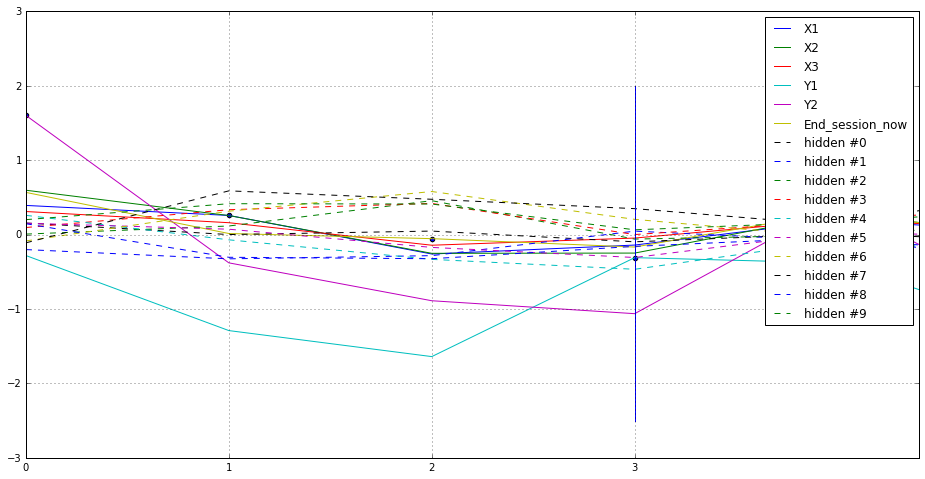

epoch 4100,loss 19.42715, epsilon 0.23428, rewards: ( e-greedy 1.41203, greedy 1.62044) 
rec 19.396 reg 0.031
epoch 4200,loss 8.41248, epsilon 0.22706, rewards: ( e-greedy 1.30416, greedy 1.52506) 
rec 8.381 reg 0.031
epoch 4300,loss 7.38334, epsilon 0.22011, rewards: ( e-greedy 1.32375, greedy 1.57255) 
rec 7.352 reg 0.032
epoch 4400,loss 4.01315, epsilon 0.21344, rewards: ( e-greedy 1.49137, greedy 1.71530) 
rec 3.981 reg 0.032
epoch 4500,loss 8.89393, epsilon 0.20703, rewards: ( e-greedy 1.45890, greedy 1.67710) 
rec 8.862 reg 0.032
epoch 4600,loss 3.28167, epsilon 0.20088, rewards: ( e-greedy 1.74634, greedy 1.90939) 
rec 3.249 reg 0.032
epoch 4700,loss 4.33575, epsilon 0.19496, rewards: ( e-greedy 2.00504, greedy 2.11845) 
rec 4.303 reg 0.033
epoch 4800,loss 8.58838, epsilon 0.18928, rewards: ( e-greedy 1.78787, greedy 2.10661) 
rec 8.555 reg 0.033
epoch 4900,loss 3.79722, epsilon 0.18382, rewards: ( e-greedy 1.75908, greedy 2.06261) 
rec 3.764 reg 0.034
epoch 5000,loss 4.13580, e

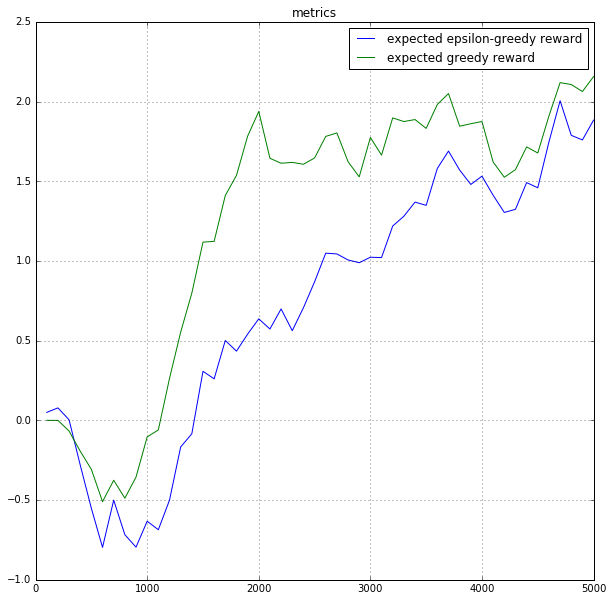

Random session examples
session # 0
 Y2(qv = 1.76259970665) -> 3.0(ref = 3.27119660378) |  X1(qv = 0.285470068455) -> -1.0(ref = -0.945624709129) |  X3(qv = 0.0572371482849) -> 1.0(ref = 0.997171878815) |  End_session_now(qv = -0.00297698378563) -> 0.0(ref = -0.0287508759648) |  X3(qv = -0.0302640795708) -> 0.0(ref = 0.0) | 



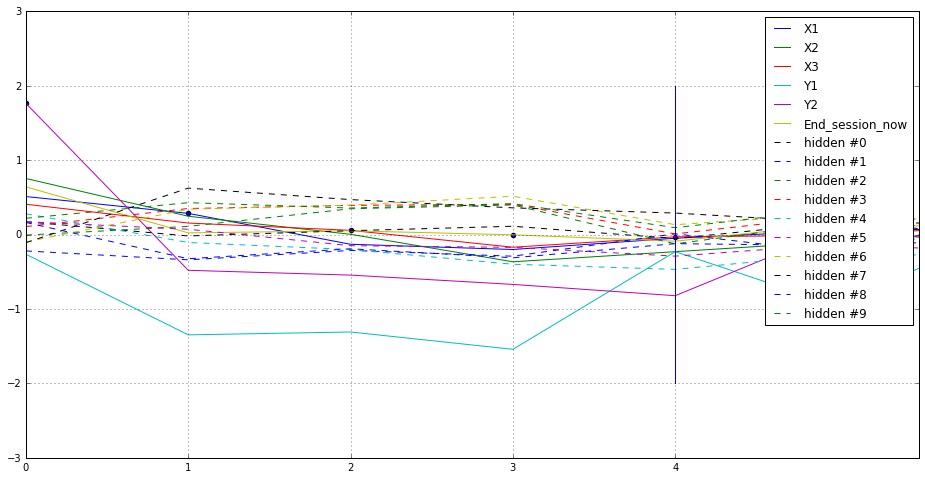

session # 1
 Y2(qv = 1.76259970665) -> 3.0(ref = 3.27119660378) |  X1(qv = 0.285470068455) -> -1.0(ref = -0.945624709129) |  X3(qv = 0.0572371482849) -> -1.0(ref = -0.842501044273) |  End_session_now(qv = 0.165788337588) -> 0.0(ref = 0.0935247987509) |  X3(qv = 0.0984471589327) -> 0.0(ref = 0.0) | 



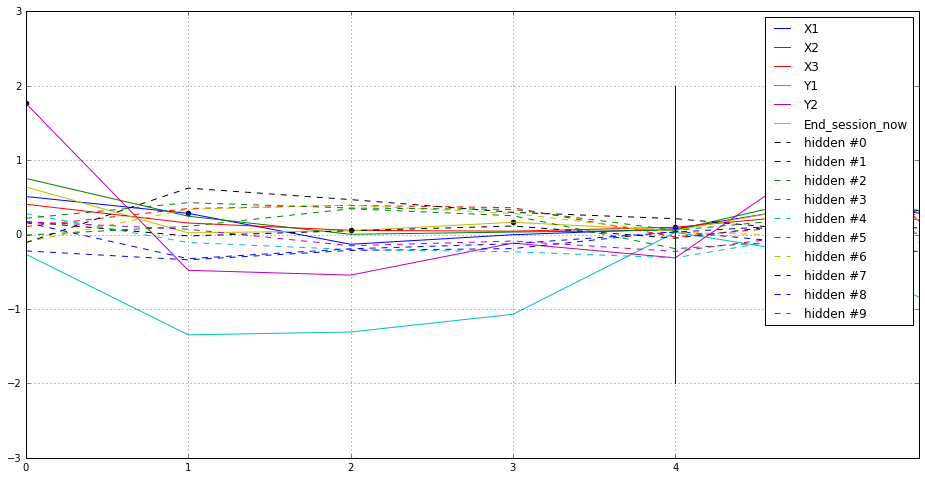

session # 2
 Y2(qv = 1.76259970665) -> 3.0(ref = 3.27119660378) |  X1(qv = 0.285470068455) -> 1.0(ref = 0.951433181763) |  End_session_now(qv = -0.0511229932308) -> 0.0(ref = -0.0429830960929) |  X3(qv = -0.0452453643084) -> 0.0(ref = 0.0) | 



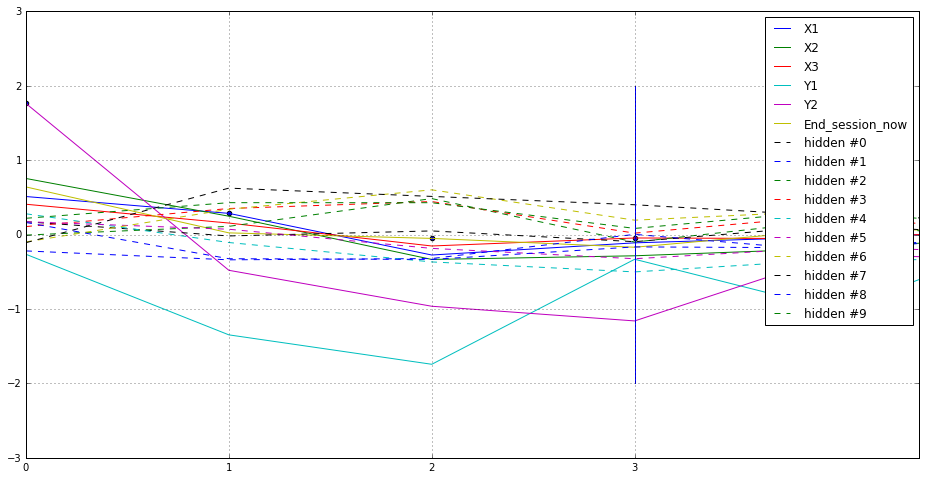

epoch 5100,loss 18.70623, epsilon 0.17353, rewards: ( e-greedy 1.67819, greedy 1.84072) 
rec 18.672 reg 0.034
epoch 5200,loss 3.67349, epsilon 0.16868, rewards: ( e-greedy 1.81037, greedy 2.02331) 
rec 3.639 reg 0.034
epoch 5300,loss 18.70325, epsilon 0.16403, rewards: ( e-greedy 1.72934, greedy 1.82098) 
rec 18.669 reg 0.034
epoch 5400,loss 8.06741, epsilon 0.15956, rewards: ( e-greedy 1.60640, greedy 1.73888) 
rec 8.033 reg 0.034
epoch 5500,loss 3.29061, epsilon 0.15526, rewards: ( e-greedy 1.76243, greedy 1.89833) 
rec 3.256 reg 0.035
epoch 5600,loss 7.78721, epsilon 0.15114, rewards: ( e-greedy 1.68619, greedy 1.80849) 
rec 7.752 reg 0.035
epoch 5700,loss 3.26268, epsilon 0.14717, rewards: ( e-greedy 1.81757, greedy 1.99431) 
rec 3.228 reg 0.035
epoch 5800,loss 7.70349, epsilon 0.14336, rewards: ( e-greedy 1.73581, greedy 1.89488) 
rec 7.668 reg 0.035
epoch 5900,loss 2.55414, epsilon 0.13970, rewards: ( e-greedy 1.92890, greedy 2.10539) 
rec 2.518 reg 0.036
epoch 6000,loss 7.77951,

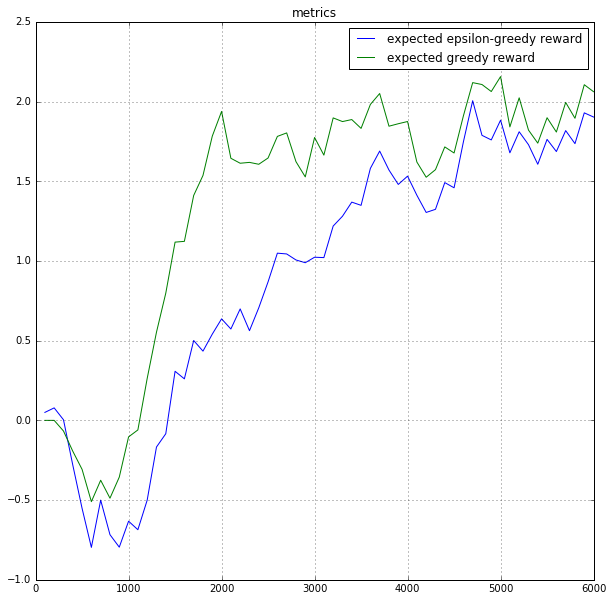

Random session examples
session # 0
 Y2(qv = 1.8978292942) -> 3.0(ref = 3.33062076569) |  X1(qv = 0.348021924496) -> 1.0(ref = 0.949562191963) |  End_session_now(qv = -0.0530924499035) -> 0.0(ref = -0.0518914163113) |  X3(qv = -0.0546225458384) -> 0.0(ref = 0.0) | 



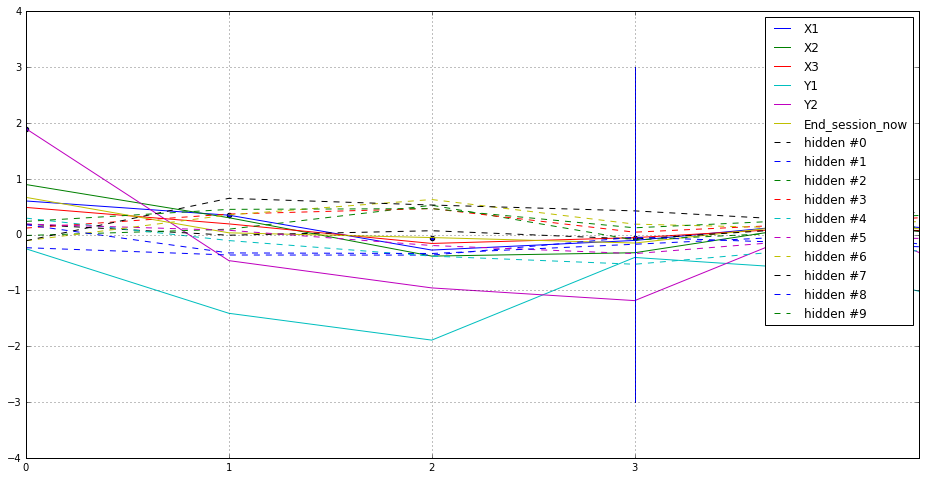

session # 1
 Y2(qv = 1.8978292942) -> -3.0(ref = -2.12163305283) |  X2(qv = 0.92459666729) -> 1.0(ref = 1.08952307701) |  X1(qv = 0.0942348241806) -> -1.0(ref = -0.79507380724) |  End_session_now(qv = 0.215711772442) -> 0.0(ref = 0.0995946675539) |  Y2(qv = -0.306779444218) -> 0.0(ref = 0.0) | 



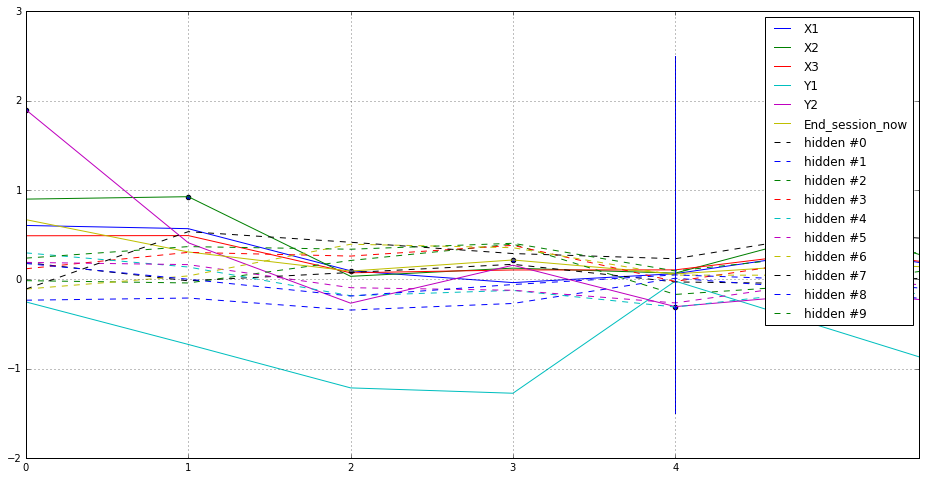

session # 2
 Y2(qv = 1.8978292942) -> 3.0(ref = 3.33062076569) |  X1(qv = 0.348021924496) -> 1.0(ref = 0.949562191963) |  End_session_now(qv = -0.0530924201012) -> 0.0(ref = -0.0518913604319) |  X3(qv = -0.0546224862337) -> 0.0(ref = 0.0) | 



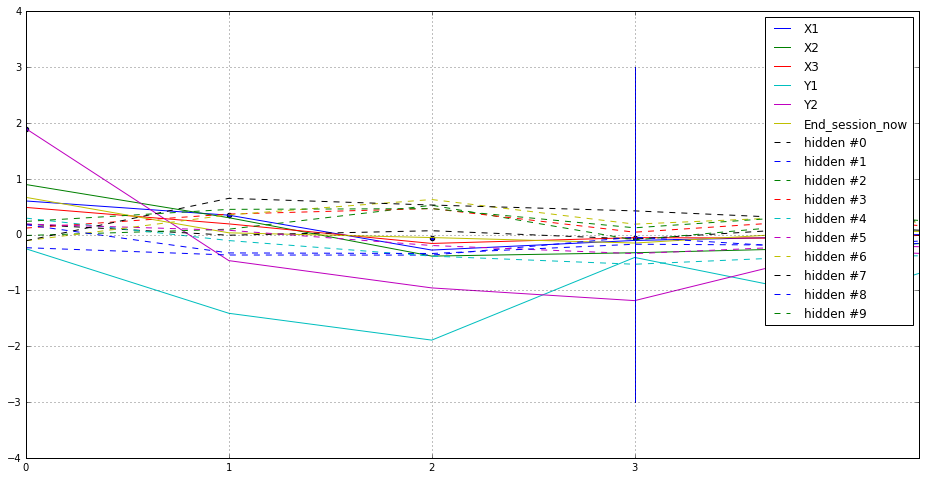

epoch 6100,loss 7.02203, epsilon 0.13280, rewards: ( e-greedy 1.91241, greedy 2.05537) 
rec 6.986 reg 0.036
epoch 6200,loss 7.73573, epsilon 0.12956, rewards: ( e-greedy 1.82117, greedy 2.04983) 
rec 7.699 reg 0.036
epoch 6300,loss 7.29494, epsilon 0.12644, rewards: ( e-greedy 1.73905, greedy 2.04485) 
rec 7.259 reg 0.036
epoch 6400,loss 7.18123, epsilon 0.12344, rewards: ( e-greedy 1.73181, greedy 2.04036) 
rec 7.145 reg 0.037
epoch 6500,loss 11.76258, epsilon 0.12056, rewards: ( e-greedy 1.49196, greedy 1.76966) 
rec 11.726 reg 0.037
epoch 6600,loss 3.76258, epsilon 0.11779, rewards: ( e-greedy 1.74277, greedy 1.92603) 
rec 3.726 reg 0.037
epoch 6700,loss 7.51426, epsilon 0.11513, rewards: ( e-greedy 1.73516, greedy 1.90009) 
rec 7.478 reg 0.037
epoch 6800,loss 3.19326, epsilon 0.11258, rewards: ( e-greedy 1.69497, greedy 2.07675) 
rec 3.156 reg 0.037
epoch 6900,loss 6.88583, epsilon 0.11013, rewards: ( e-greedy 1.72548, greedy 2.06907) 
rec 6.849 reg 0.037
epoch 7000,loss 2.89943, e

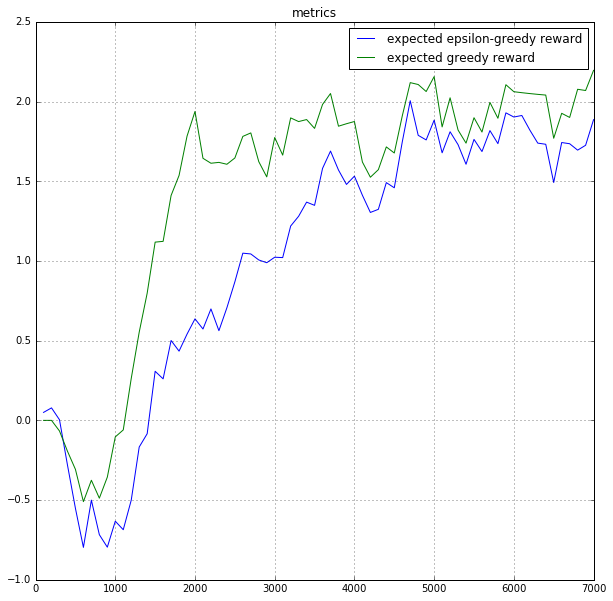

Random session examples
session # 0
 Y2(qv = 1.93089568615) -> -3.0(ref = -2.02998375893) |  X2(qv = 1.02106976509) -> 1.0(ref = 1.08357954025) |  End_session_now(qv = 0.0879785120487) -> 0.0(ref = 0.0835736989975) |  X3(qv = 0.0879723131657) -> 0.0(ref = 0.0) | 



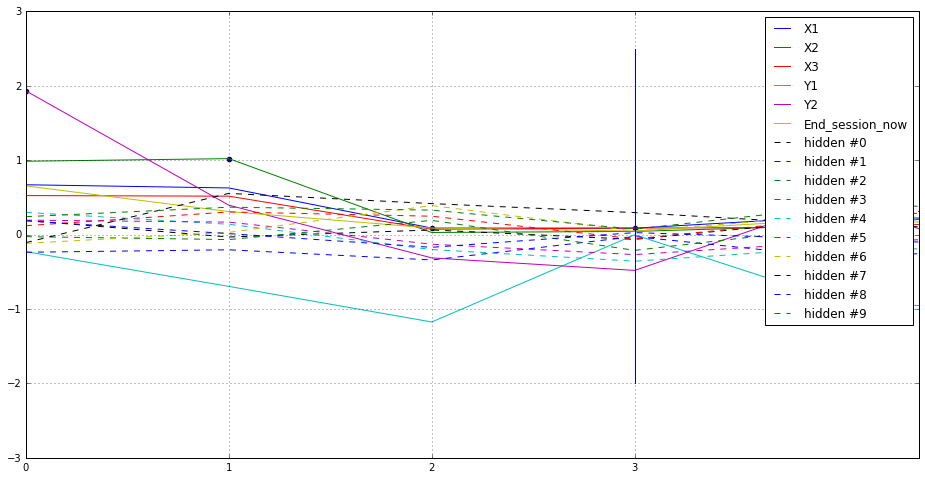

session # 1
 Y2(qv = 1.93089568615) -> 3.0(ref = 3.36334896088) |  X1(qv = 0.382472634315) -> 1.0(ref = 0.969364404678) |  End_session_now(qv = -0.0322480201721) -> 0.0(ref = -0.0292429830879) |  X3(qv = -0.0307820886374) -> 0.0(ref = 0.0) | 



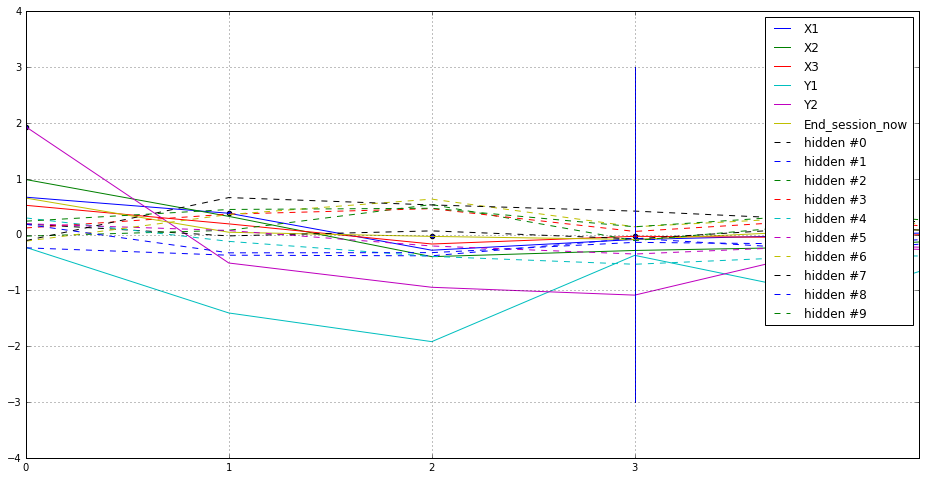

session # 2
 Y2(qv = 1.93089580536) -> 3.0(ref = 3.36334896088) |  X1(qv = 0.382472634315) -> -1.0(ref = -0.935118377209) |  End_session_now(qv = 0.0682964622974) -> 0.0(ref = 0.0616760030389) |  X3(qv = 0.0649221092463) -> 0.0(ref = 0.0) | 



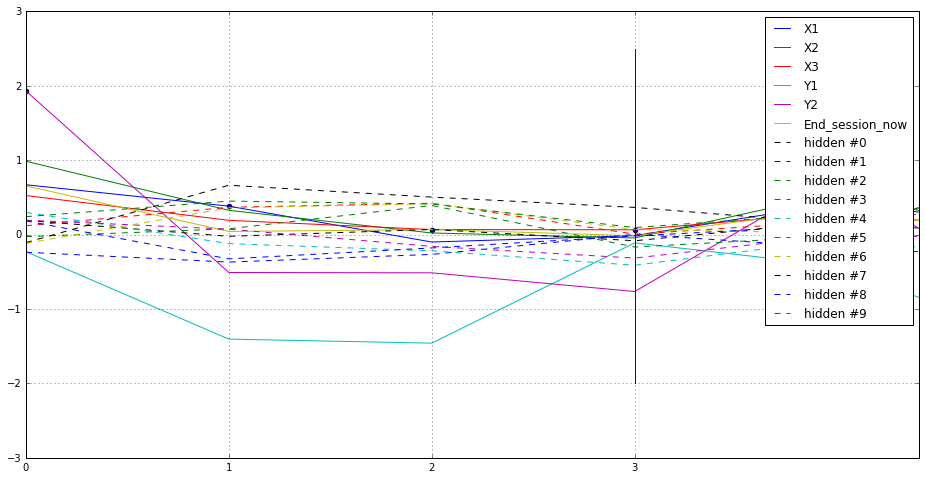

epoch 7100,loss 16.84598, epsilon 0.10550, rewards: ( e-greedy 1.71430, greedy 1.90928) 
rec 16.809 reg 0.037
epoch 7200,loss 2.82256, epsilon 0.10333, rewards: ( e-greedy 1.87621, greedy 2.05169) 
rec 2.785 reg 0.037
epoch 7300,loss 6.83441, epsilon 0.10124, rewards: ( e-greedy 1.88859, greedy 2.04652) 
rec 6.797 reg 0.037
epoch 7400,loss 11.86164, epsilon 0.09923, rewards: ( e-greedy 1.63306, greedy 1.77520) 
rec 11.824 reg 0.037
epoch 7500,loss 2.33094, epsilon 0.09730, rewards: ( e-greedy 1.71975, greedy 1.93101) 
rec 2.293 reg 0.038
epoch 7600,loss 2.92172, epsilon 0.09544, rewards: ( e-greedy 1.88111, greedy 2.07125) 
rec 2.884 reg 0.038
epoch 7700,loss 7.00165, epsilon 0.09366, rewards: ( e-greedy 1.82633, greedy 2.06412) 
rec 6.964 reg 0.038
epoch 7800,loss 6.75091, epsilon 0.09195, rewards: ( e-greedy 1.81037, greedy 2.05771) 
rec 6.713 reg 0.038
epoch 7900,loss 7.70476, epsilon 0.09030, rewards: ( e-greedy 1.69600, greedy 1.91861) 
rec 7.667 reg 0.038
epoch 8000,loss 1.92517,

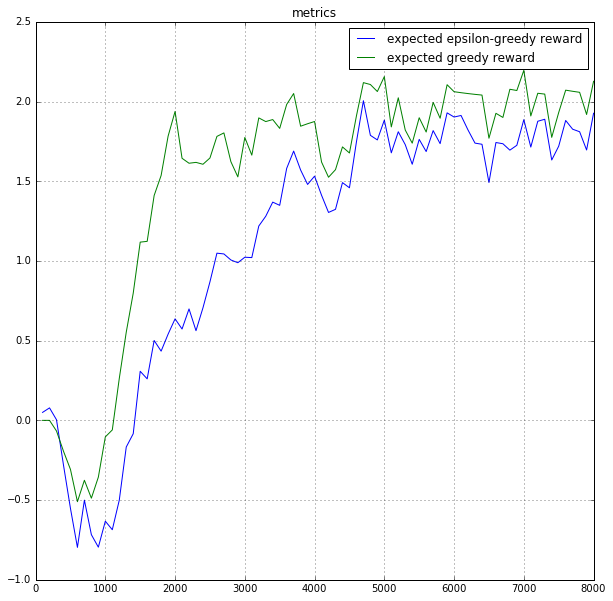

Random session examples
session # 0
 Y2(qv = 2.07191038132) -> 3.0(ref = 3.26319479942) |  X1(qv = 0.277047246695) -> 1.0(ref = 0.959494948387) |  End_session_now(qv = -0.0426369011402) -> 0.0(ref = -0.0407556332648) |  X3(qv = -0.0429006665945) -> 0.0(ref = 0.0) | 



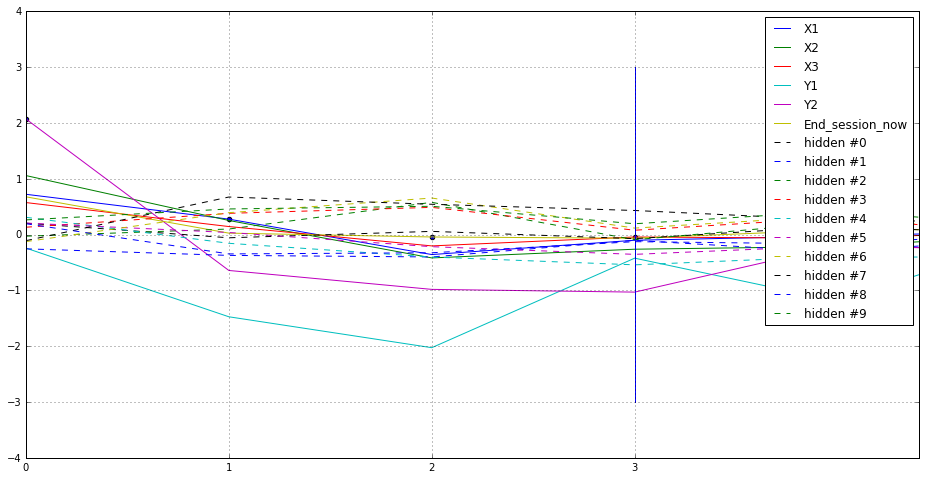

session # 1
 End_session_now(qv = 0.677039027214) -> 0.0(ref = 0.869841575623) |  Y2(qv = 0.915622711182) -> 0.0(ref = 0.0) | 



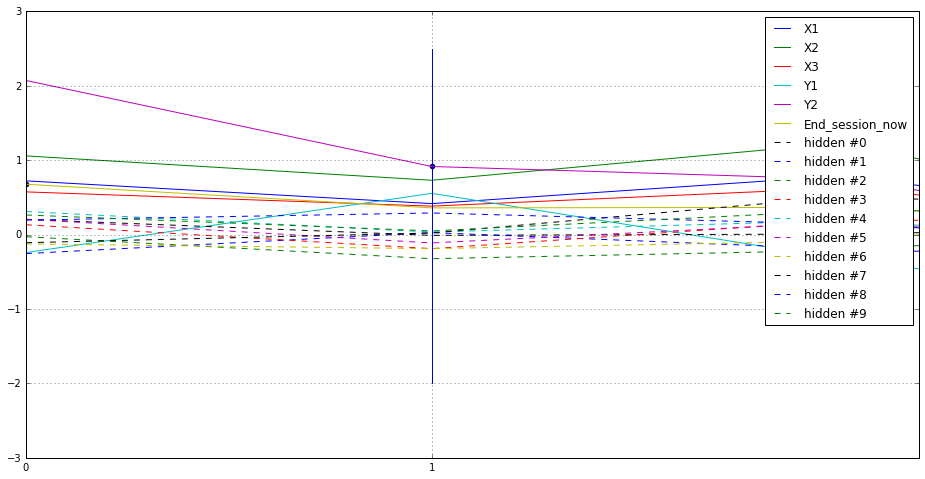

session # 2
 Y2(qv = 2.07191038132) -> 3.0(ref = 3.26319479942) |  X1(qv = 0.277047246695) -> -1.0(ref = -0.939362704754) |  X3(qv = 0.0420587807894) -> -1.0(ref = -0.861062765121) |  End_session_now(qv = 0.146249726415) -> 0.0(ref = 0.070025369525) |  End_session_now(qv = 0.0737109184265) -> 0.0(ref = 0.0) | 



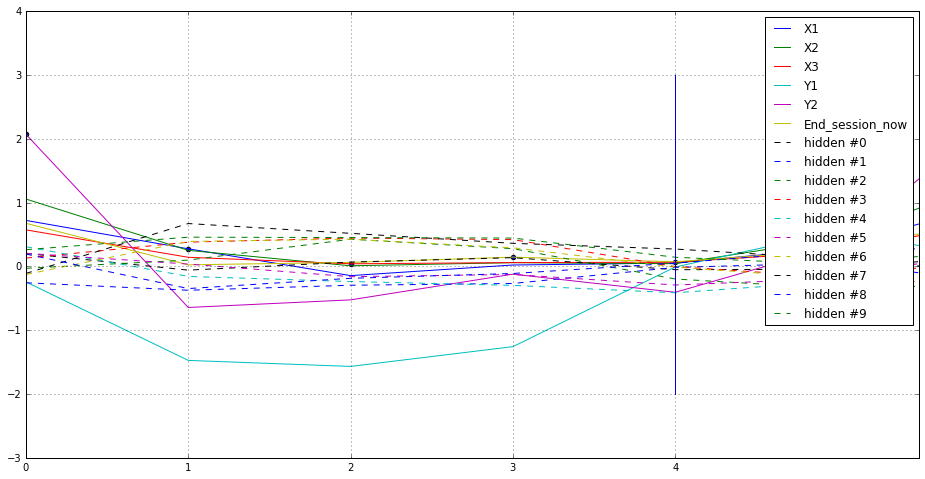

epoch 8100,loss 2.60989, epsilon 0.08721, rewards: ( e-greedy 1.96709, greedy 2.24740) 
rec 2.572 reg 0.038
epoch 8200,loss 2.76277, epsilon 0.08575, rewards: ( e-greedy 2.03705, greedy 2.28933) 
rec 2.724 reg 0.038
epoch 8300,loss 2.44367, epsilon 0.08435, rewards: ( e-greedy 2.16668, greedy 2.39373) 
rec 2.405 reg 0.038
epoch 8400,loss 6.97224, epsilon 0.08300, rewards: ( e-greedy 2.15001, greedy 2.35436) 
rec 6.934 reg 0.038
epoch 8500,loss 1.62645, epsilon 0.08170, rewards: ( e-greedy 2.16834, greedy 2.51892) 
rec 1.588 reg 0.038
epoch 8600,loss 6.84352, epsilon 0.08046, rewards: ( e-greedy 2.10151, greedy 2.46703) 
rec 6.805 reg 0.039
epoch 8700,loss 2.01058, epsilon 0.07927, rewards: ( e-greedy 2.29136, greedy 2.62033) 
rec 1.972 reg 0.039
epoch 8800,loss 11.85152, epsilon 0.07812, rewards: ( e-greedy 2.06222, greedy 2.35829) 
rec 11.813 reg 0.039
epoch 8900,loss 4.18763, epsilon 0.07702, rewards: ( e-greedy 2.08933, greedy 2.35580) 
rec 4.149 reg 0.039
epoch 9000,loss 7.63163, e

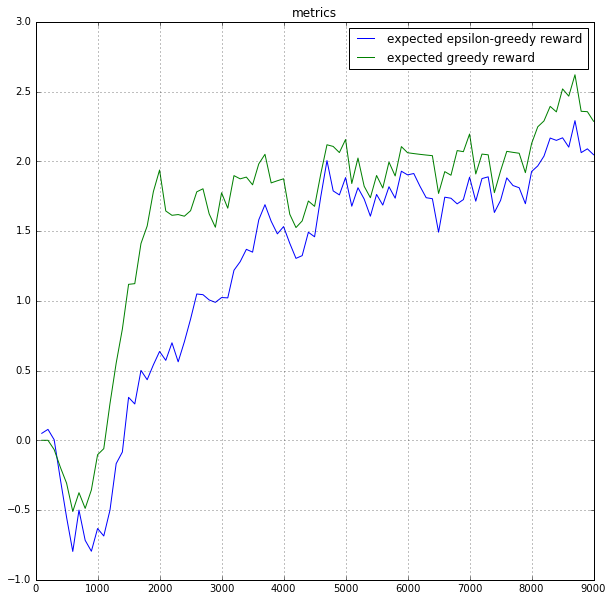

Random session examples
session # 0
 Y2(qv = 2.13673210144) -> 3.0(ref = 3.30126929283) |  X1(qv = 0.317125588655) -> 1.0(ref = 0.966604411602) |  End_session_now(qv = -0.0351532697678) -> 0.0(ref = -0.0249900370836) |  X3(qv = -0.0263053029776) -> 0.0(ref = 0.0) | 



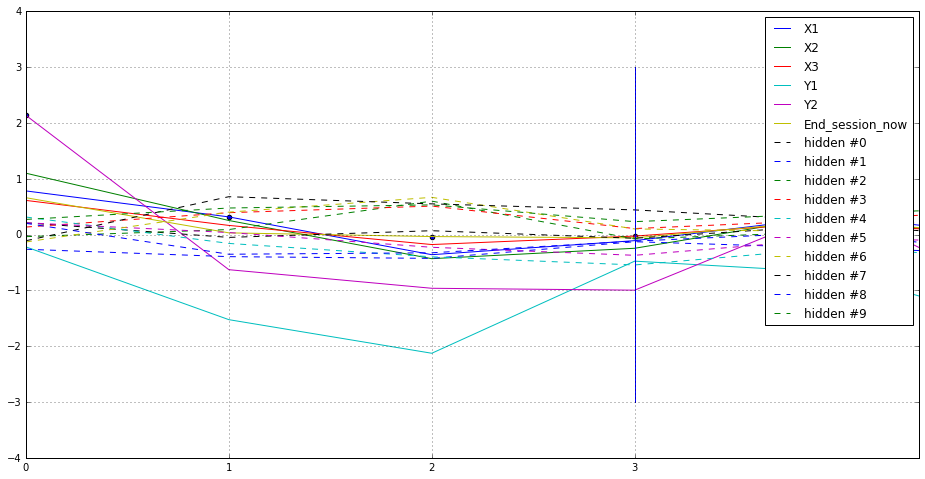

session # 1
 Y2(qv = 2.13673210144) -> 3.0(ref = 3.30126929283) |  X1(qv = 0.317125588655) -> 1.0(ref = 0.966604411602) |  End_session_now(qv = -0.0351532697678) -> 0.0(ref = -0.0249900370836) |  X3(qv = -0.0263053029776) -> 0.0(ref = 0.0) | 



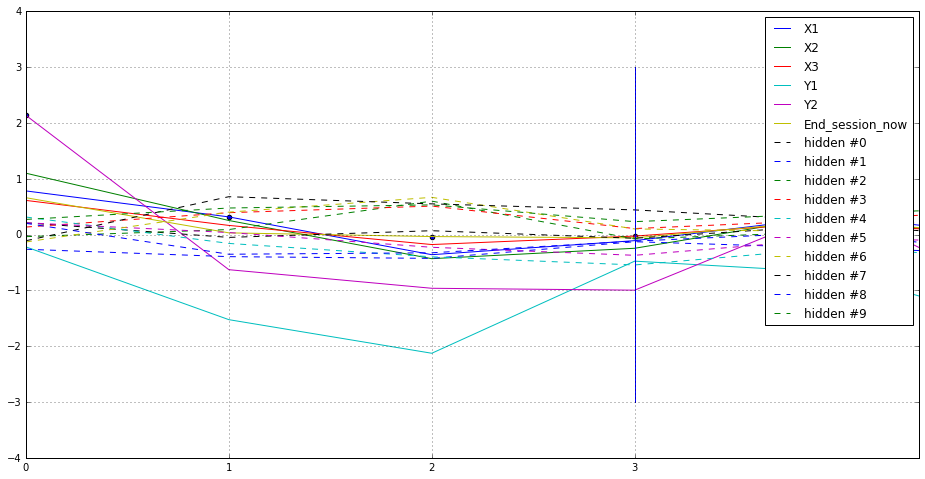

session # 2
 Y2(qv = 2.13673210144) -> 3.0(ref = 3.30126929283) |  X1(qv = 0.317125588655) -> -1.0(ref = -0.940366566181) |  X1(qv = -0.136892437935) -> -0.5(ref = -0.3692933321) |  End_session_now(qv = 0.13758598268) -> 0.0(ref = 0.0651369467378) |  X3(qv = 0.0685652047396) -> 0.0(ref = 0.0) | 



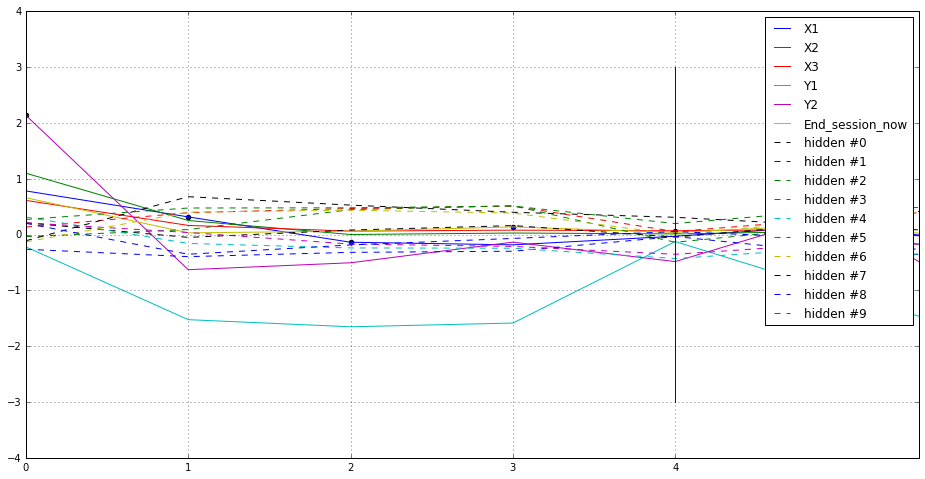

epoch 9100,loss 7.30722, epsilon 0.07494, rewards: ( e-greedy 1.97569, greedy 2.19153) 
rec 7.268 reg 0.039
epoch 9200,loss 1.94447, epsilon 0.07396, rewards: ( e-greedy 2.17812, greedy 2.37238) 
rec 1.905 reg 0.039
epoch 9300,loss 3.42273, epsilon 0.07302, rewards: ( e-greedy 2.26031, greedy 2.46847) 
rec 3.384 reg 0.039
epoch 9400,loss 2.31759, epsilon 0.07212, rewards: ( e-greedy 2.36761, greedy 2.55496) 
rec 2.279 reg 0.039
epoch 9500,loss 2.82281, epsilon 0.07125, rewards: ( e-greedy 2.39752, greedy 2.56613) 
rec 2.784 reg 0.039
epoch 9600,loss 6.91532, epsilon 0.07042, rewards: ( e-greedy 2.35777, greedy 2.50952) 
rec 6.876 reg 0.039
epoch 9700,loss 7.35194, epsilon 0.06962, rewards: ( e-greedy 2.25532, greedy 2.39190) 
rec 7.313 reg 0.039
epoch 9800,loss 2.79392, epsilon 0.06885, rewards: ( e-greedy 2.37979, greedy 2.51937) 
rec 2.755 reg 0.039
epoch 9900,loss 2.84353, epsilon 0.06811, rewards: ( e-greedy 2.42515, greedy 2.55077) 
rec 2.804 reg 0.039
epoch 10000,loss 8.71390, ep

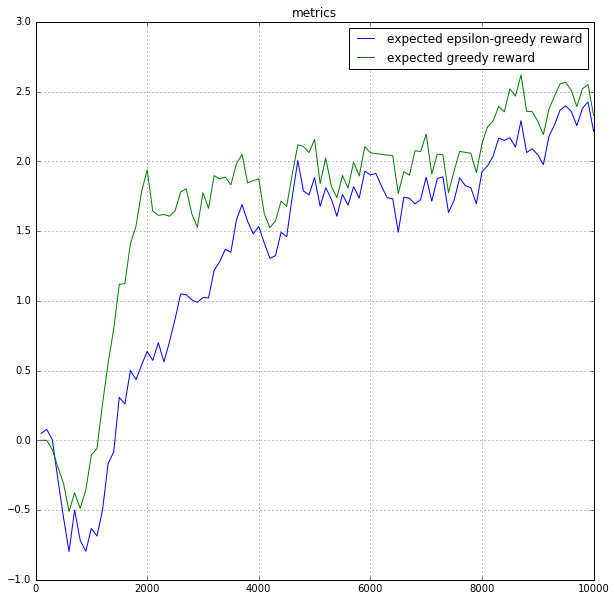

Random session examples
session # 0
 Y2(qv = 2.06260895729) -> 3.0(ref = 3.30977010727) |  X1(qv = 0.32607370615) -> 1.0(ref = 0.956927418709) |  End_session_now(qv = -0.0453395545483) -> 0.0(ref = -0.0349477231503) |  X3(qv = -0.0367870777845) -> 0.0(ref = 0.0) | 



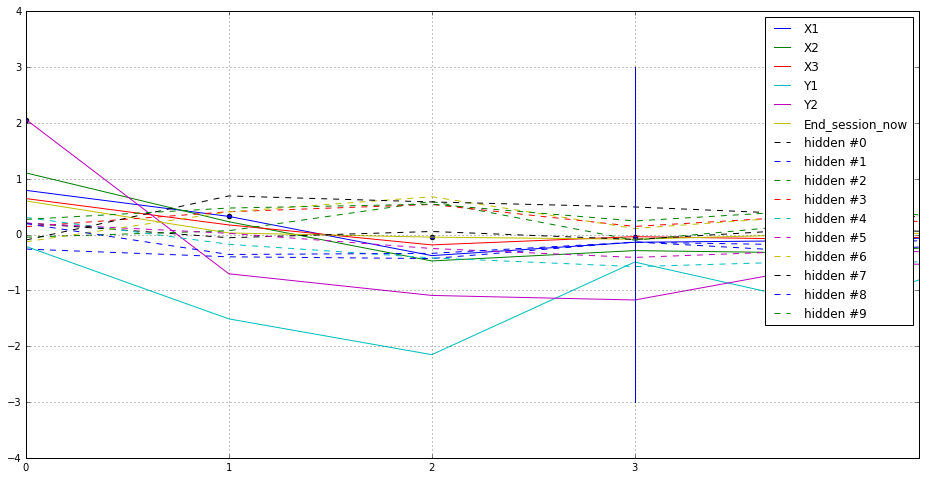

session # 1
 Y2(qv = 2.06260895729) -> 3.0(ref = 3.30977010727) |  X1(qv = 0.32607370615) -> 1.0(ref = 0.956927418709) |  End_session_now(qv = -0.0453395545483) -> 0.0(ref = -0.0349477231503) |  X3(qv = -0.0367870777845) -> 0.0(ref = 0.0) | 



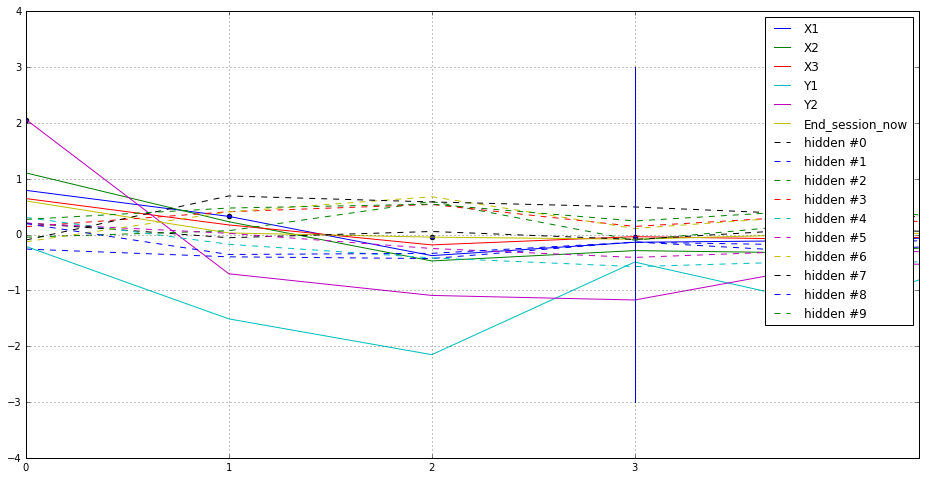

session # 2
 Y2(qv = 2.06260919571) -> 3.0(ref = 3.30977010727) |  X1(qv = 0.32607370615) -> 1.0(ref = 0.956927418709) |  End_session_now(qv = -0.0453395843506) -> 0.0(ref = -0.0349477529526) |  X3(qv = -0.0367871075869) -> 0.0(ref = 0.0) | 



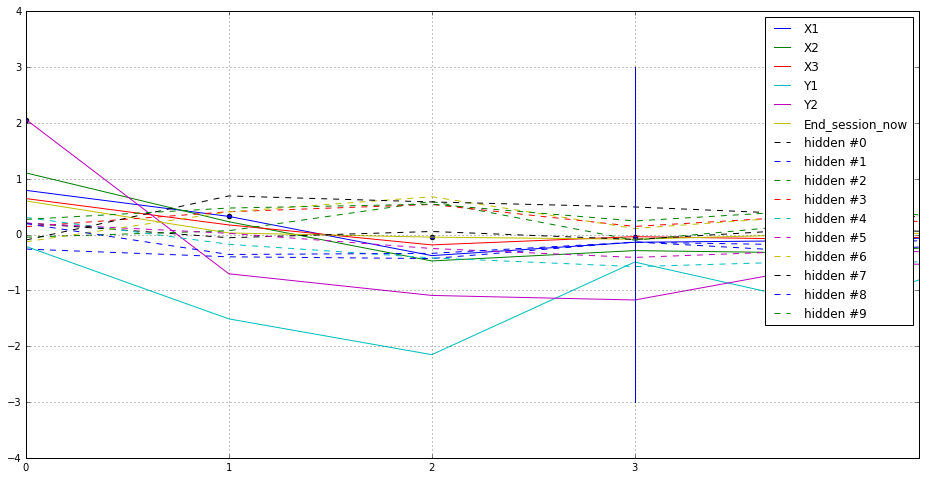

In [25]:
n_epochs = 10000
batch_size=3

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %1000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results
* in this case, a network has obvoiusly not converged, so actions ought to be suboptimal
* running network for longer may yield better results

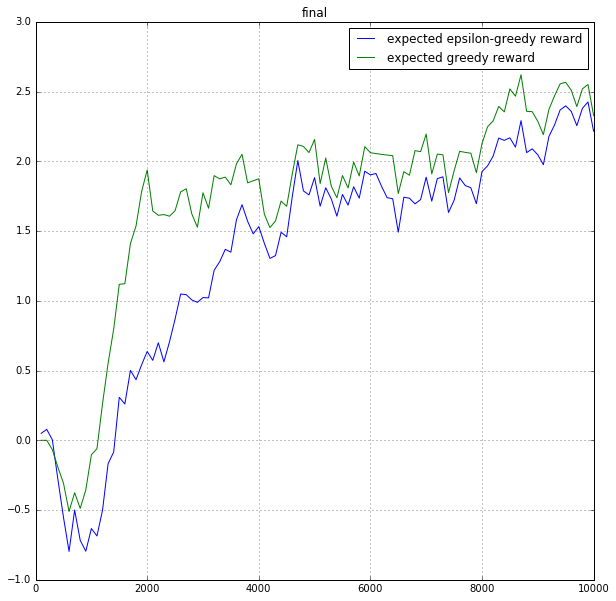

In [26]:
score_log.plot("final")

Random session examples
session # 0
 Y2(qv = 2.06260895729) -> 3.0(ref = 3.30976986885) |  X1(qv = 0.326073646545) -> 1.0(ref = 0.956927418709) |  End_session_now(qv = -0.0453395545483) -> 0.0(ref = -0.034947834909) |  X3(qv = -0.0367871969938) -> 0.0(ref = 0.0) | 



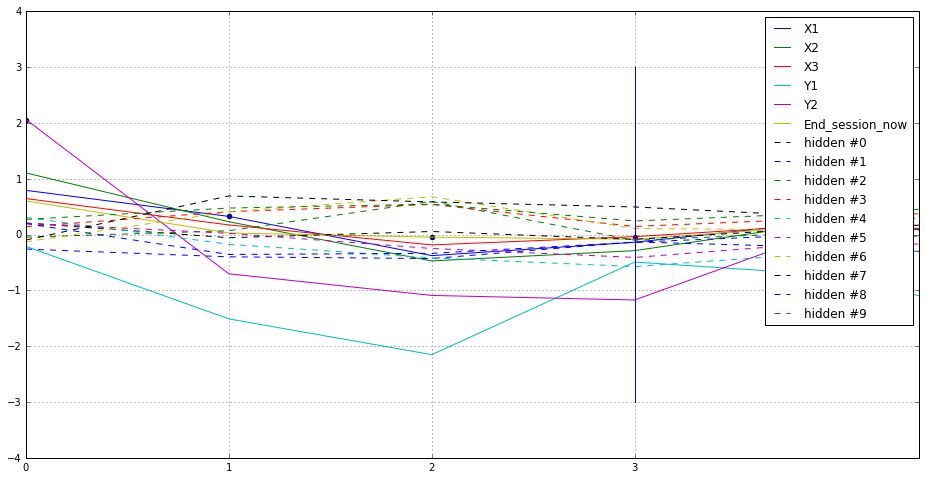

session # 1
 Y2(qv = 2.06260895729) -> 3.0(ref = 3.30976986885) |  X1(qv = 0.326073646545) -> -1.0(ref = -0.958064615726) |  X3(qv = 0.0441425293684) -> -1.0(ref = -0.946396589279) |  End_session_now(qv = 0.0564246177673) -> 0.0(ref = 0.0256559401751) |  X3(qv = 0.0270062536001) -> 0.0(ref = 0.0) | 



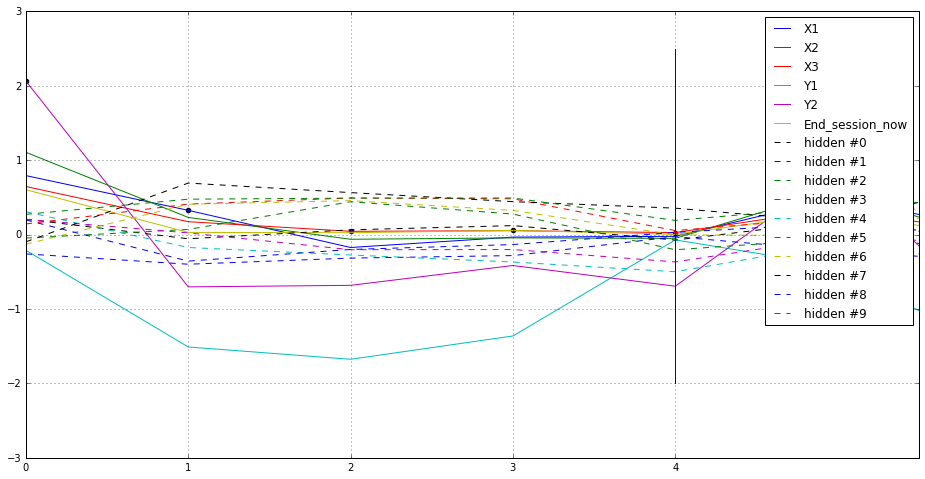

session # 2
 Y2(qv = 2.06260895729) -> 3.0(ref = 3.30976986885) |  X1(qv = 0.326073646545) -> 1.0(ref = 0.956927418709) |  End_session_now(qv = -0.0453395545483) -> 0.0(ref = -0.034947834909) |  X3(qv = -0.0367871969938) -> 0.0(ref = 0.0) | 



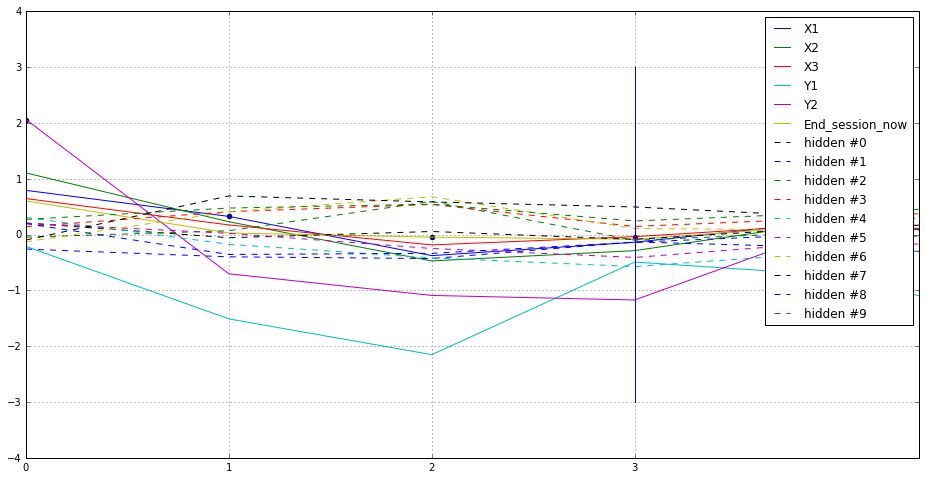

session # 3
 Y2(qv = 2.06260895729) -> 3.0(ref = 3.30976986885) |  X1(qv = 0.326073646545) -> 1.0(ref = 0.956927418709) |  End_session_now(qv = -0.0453395545483) -> 0.0(ref = -0.034947834909) |  X3(qv = -0.0367871969938) -> 0.0(ref = 0.0) | 



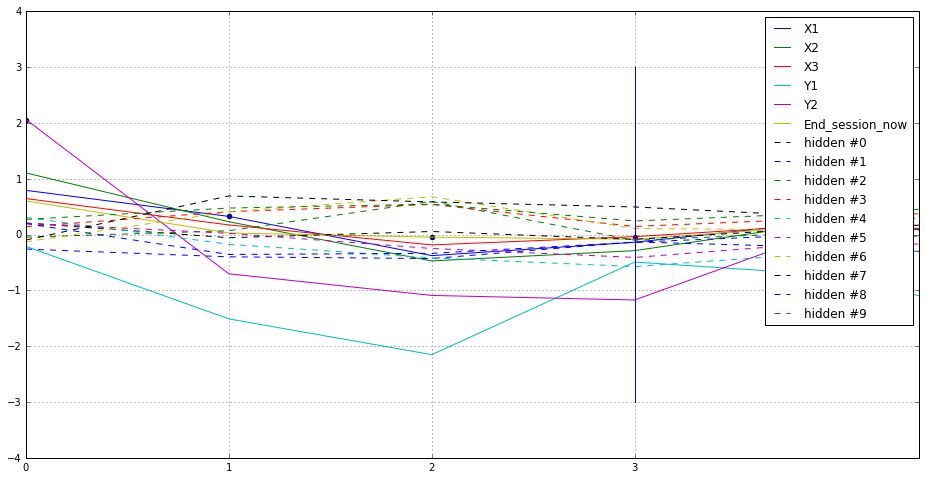

session # 4
 Y2(qv = 2.06260919571) -> -3.0(ref = -2.03242182732) |  X2(qv = 1.01850342751) -> 1.0(ref = 1.04198181629) |  X3(qv = 0.0441913753748) -> -1.0(ref = -0.882495582104) |  End_session_now(qv = 0.123688861728) -> 0.0(ref = 0.0555180981755) |  X3(qv = 0.0584401041269) -> 0.0(ref = 0.0) | 



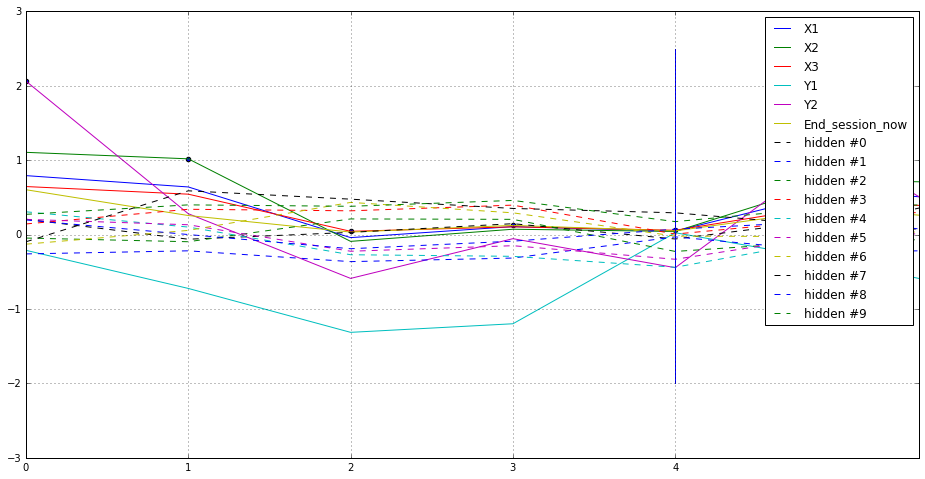

session # 5
 Y2(qv = 2.06260895729) -> -3.0(ref = -2.03242182732) |  X2(qv = 1.01850342751) -> 1.0(ref = 1.04198181629) |  X3(qv = 0.0441914051771) -> 1.0(ref = 0.98115336895) |  End_session_now(qv = -0.0198385417461) -> 0.0(ref = -0.0236637387425) |  End_session_now(qv = -0.0249091982841) -> 0.0(ref = 0.0) | 



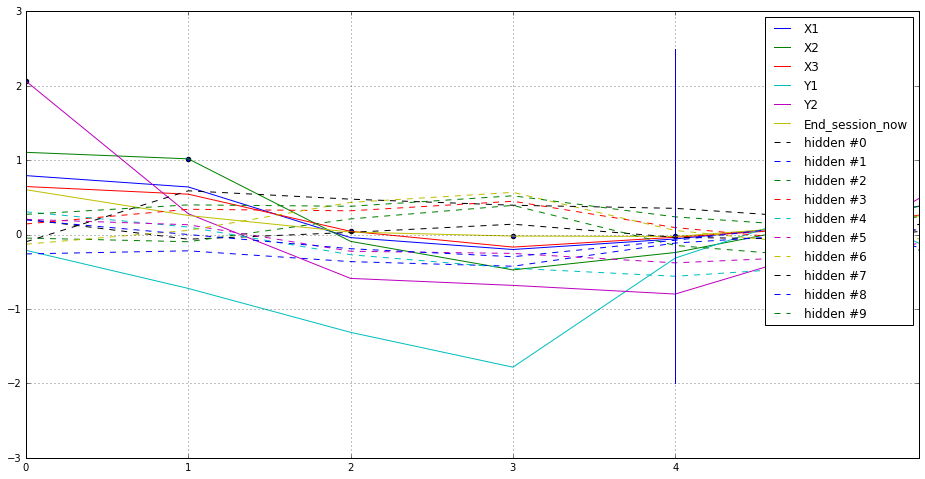

session # 6
 Y2(qv = 2.06260895729) -> 3.0(ref = 3.30976986885) |  X1(qv = 0.326073646545) -> -1.0(ref = -0.958064615726) |  X3(qv = 0.0441425293684) -> 1.0(ref = 0.925994932652) |  End_session_now(qv = -0.0779000520706) -> 0.0(ref = -0.053299497813) |  X3(qv = -0.05610473454) -> 0.0(ref = 0.0) | 



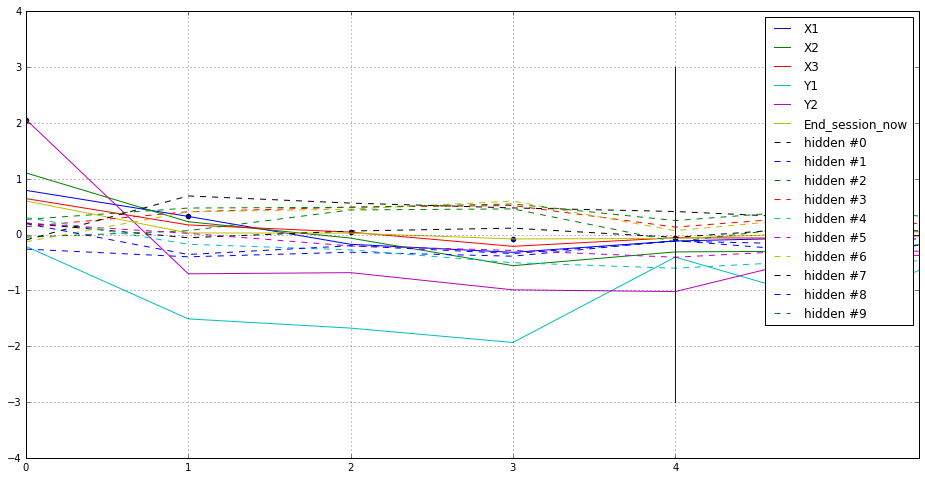

session # 7
 Y2(qv = 2.06260895729) -> 3.0(ref = 3.30976986885) |  X1(qv = 0.326073646545) -> 1.0(ref = 0.956927418709) |  End_session_now(qv = -0.0453395545483) -> 0.0(ref = -0.034947834909) |  X3(qv = -0.0367871969938) -> 0.0(ref = 0.0) | 



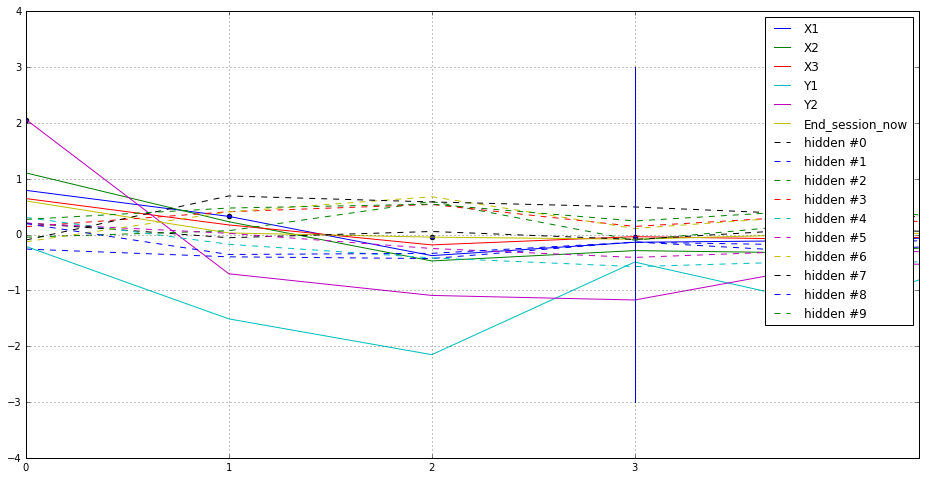

session # 8
 Y2(qv = 2.06260895729) -> 3.0(ref = 3.30976986885) |  X1(qv = 0.326073646545) -> 1.0(ref = 0.956927418709) |  End_session_now(qv = -0.0453395545483) -> 0.0(ref = -0.034947834909) |  X3(qv = -0.0367871969938) -> 0.0(ref = 0.0) | 



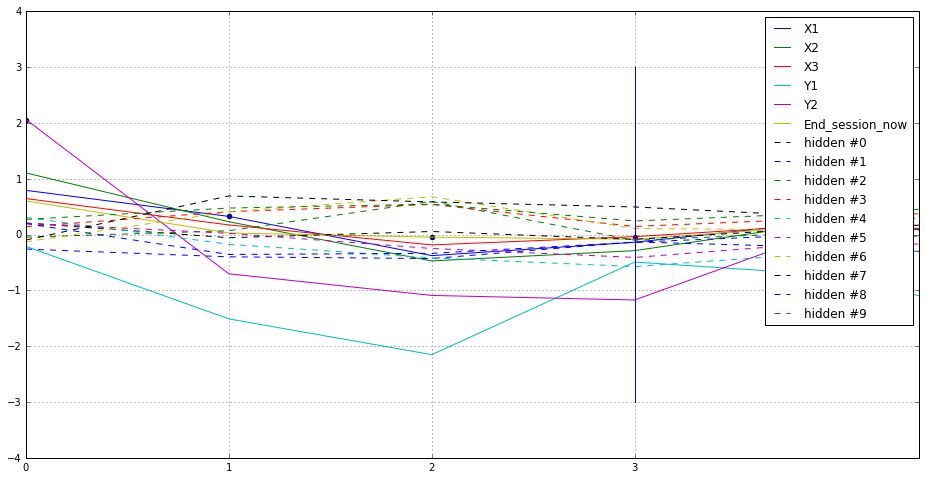

session # 9
 Y2(qv = 2.06260919571) -> -3.0(ref = -2.03242182732) |  X2(qv = 1.01850342751) -> 1.0(ref = 1.04198181629) |  X3(qv = 0.0441913753748) -> -1.0(ref = -0.882495582104) |  End_session_now(qv = 0.123688861728) -> 0.0(ref = 0.0555180981755) |  X3(qv = 0.0584401041269) -> 0.0(ref = 0.0) | 



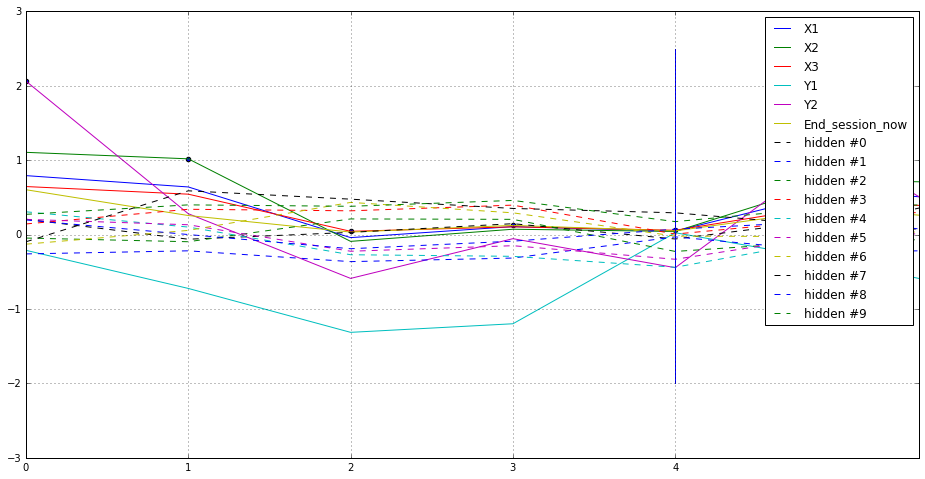

In [27]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
